In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.stats

c:\Users\Kyuho\anaconda3\envs\helix\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
SEED = 172
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

TRAIN_RATIO = 0.8
BATCH_SIZE = 1024
LEARNING_RATE = 0.001
# LEARNING_RATE = 0.001
EPOCH = 60

ENCODER_PATH = 'C:\\Users\\Kyuho\\code\\UCI\\helix\\variance_predict\\gaussian\\weighted_separated_results1\\encoder_epoch_150.pth'
HELIX_PATH = "C:\\Users\\Kyuho\\code\\UCI\\helix\\tracks_100k_updated.txt"
VARIANCE_SAVE_PATH = 'C:\\Users\\Kyuho\\code\\UCI\\helix\\temp_save\\variance_tensor_epoch_150_weighted_separated.pt'
DISTANCE_SAVE_PATH =  'C:\\Users\\Kyuho\\code\\UCI\\helix\\temp_save\\distance_tensor_epoch_150_weighted_separated.pt'

In [3]:
class Dataset(Dataset):
    def __init__(self, path, transform=None):
        with open(path, 'r') as file:
            content = file.read()
            data_points = content.split('EOT')

            data_points = [dp.strip() for dp in data_points if dp.strip()]
            data_points = [dp.split('\n') for dp in data_points]
            data_points = [[[float(cell) for cell in row.split(', ')] for row in dp] for dp in data_points]
            self.original_targets = np.array([dp[0] for dp in data_points])
            input_points = [dp[1:] for dp in data_points]
            targets_2 = np.delete(self.original_targets, 1, 1)
            targets_2 = np.hstack((targets_2, np.cos(self.original_targets[:, 1])[..., None]))
            targets_cos_sin = np.hstack((targets_2, np.sin(self.original_targets[:, 1])[..., None]))
            self.scaler_cos_sin = MinMaxScaler()
            self.scaler_original = MinMaxScaler()
            
            self.rescaled_targets_cos_sin = self.scaler_cos_sin.fit_transform(targets_cos_sin)
            self.rescaled_targets_cos_sin = torch.tensor(self.rescaled_targets_cos_sin)
            self.original_targets_cos_sin = torch.tensor(targets_cos_sin)

            self.rescaled_targets_original = self.scaler_original.fit_transform(self.original_targets)
            self.rescaled_targets_original = torch.tensor(self.rescaled_targets_original)
            self.original_targets = torch.tensor(self.original_targets)
            inputs = []
            for input in input_points:
                combined = []
                for coordinate in input:
                    combined += coordinate
                inputs.append(combined)
            self.inputs = torch.tensor(np.array(inputs))
            # self.inputs = torch.tensor(np.array(input_points))

    def __len__(self):
        return len(self.rescaled_targets_cos_sin)

    def __getitem__(self, idx):
        target = self.original_targets[idx]
        input = self.inputs[idx]
        return input, target

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # self.layer1 = nn.Linear(30, 32)
        # self.layer2 = nn.Linear(32, 64)
        # self.layer3 = nn.Linear(64, 5)
        self.layer1_mean = nn.Linear(30, 200)
        self.layer2_mean = nn.Linear(200, 400)
        self.layer3_mean = nn.Linear(400, 800)
        self.layer4_mean = nn.Linear(800, 800)
        self.layer5_mean = nn.Linear(800, 800)
        self.layer6_mean = nn.Linear(800, 400)
        self.layer7_mean = nn.Linear(400, 200)
        self.output_layer_mean = nn.Linear(200, 6)

        self.layer1_var = nn.Linear(30, 200)
        self.layer2_var = nn.Linear(200, 400)
        self.layer3_var = nn.Linear(400, 400)
        self.layer4_var = nn.Linear(400, 200)
        self.output_layer_var = nn.Linear(200, 6)


    def forward(self, input):
        x = F.leaky_relu(self.layer1_mean(input))
        x = F.leaky_relu(self.layer2_mean(x))
        x = F.leaky_relu(self.layer3_mean(x))
        x = F.leaky_relu(self.layer4_mean(x))
        x = F.leaky_relu(self.layer5_mean(x))
        x = F.leaky_relu(self.layer6_mean(x))
        x = F.leaky_relu(self.layer7_mean(x))
        mean = self.output_layer_mean(x)

        x = F.relu(self.layer1_var(input))
        x = F.relu(self.layer2_var(x))
        x = F.relu(self.layer3_var(x))
        x = F.relu(self.layer4_var(x))
        var = F.relu(self.output_layer_var(x))

        return mean, var

In [5]:
def wrap_angles_torch(angles):
    """Wrap angles to be within the range [0, 2π] in PyTorch."""
    two_pi = 2 * torch.pi  # Define 2π in PyTorch
    return angles % two_pi

def track_torch(phi, d0, phi0, pt, dz, tanl):
    alpha = 1 / 2  # 1/cB
    q = 1
    kappa = q / pt
    rho = alpha / kappa
    x = d0 * torch.cos(phi0) + rho * (torch.cos(phi0) - torch.cos(phi0 + phi))
    y = d0 * torch.sin(phi0) + rho * (torch.sin(phi0) - torch.sin(phi0 + phi))
    z = dz - rho * tanl * phi
    return x, y, z

def fast_find_phi_torch(iphi, r02, d0, phi0, pt, dz, tanl, tolerance=0.01, max_iter=500):
    ra2 = torch.zeros(d0.size(), device=d0.device)
    phia = torch.zeros(d0.size(), device=d0.device)
    phib = torch.full(d0.size(), iphi, device=d0.device)

    for i in range(max_iter):
        xb, yb, zb = track_torch(phib, d0, phi0, pt, dz, tanl)
        rb2 = (xb * xb + yb * yb).float()
        delta_r = (rb2 - ra2).abs()

        # Print statements for debugging
        #print(f"Iteration {i}:")
        #print("phib:", phib)
        #print("phia:", phia)
        #print("ra2:", ra2)
        #print("rb2:", rb2)
        #print("delta_r:", delta_r)
        #print("r02:", r02)
        
        # Stop if all deltas are below tolerance
        if (delta_r < tolerance).all():
            #print("Convergence achieved.")
            break

        # Mask for (rb2 > r02) and (ra2 < r02)
        mask1 = (rb2 > r02) & (ra2 < r02)
        phib[mask1] = phia[mask1] + (phib[mask1] - phia[mask1]) * (r02[mask1] - ra2[mask1]) / (rb2[mask1] - ra2[mask1] + 1e-10)
        #phib = wrap_angles_torch(phib)

        # Mask for (rb2 < r02) and (ra2 < r02), excluding elements affected by mask1
        mask2 = (rb2 < r02) & (ra2 < r02) & ~mask1
        phibnew = phib.clone()
        phibnew[mask2] = phia[mask2] + (phib[mask2] - phia[mask2]) * (r02[mask2] - ra2[mask2]) / (rb2[mask2] - ra2[mask2] + 1e-10)
        #phibnew = wrap_angles_torch(phibnew)
        phia[mask2] = phib[mask2]
        ra2[mask2] = rb2[mask2]
        phib[mask2] = phibnew[mask2]


        # Mask for (rb2 > r02) and (ra2 > r02), excluding elements affected by mask1 and mask2
        mask3 = (rb2 > r02) & (ra2 > r02) & ~mask1 & ~mask2
        phianew = phia.clone()
        phianew[mask3] = phib[mask3] + (phia[mask3] - phib[mask3]) * (r02[mask3] - rb2[mask3]) / (ra2[mask3] - rb2[mask3] + 1e-10)
        #phianew = wrap_angles_torch(phianew)
        phib[mask3] = phia[mask3]
        rb2[mask3] = ra2[mask3]
        phia[mask3] = phianew[mask3]

        #phia = wrap_angles_torch(phia)
        #phib = wrap_angles_torch(phib)

        # Recalculate rb2 for elements where phib was modified by mask1
        xb, yb, zb = track_torch(phib, d0, phi0, pt, dz, tanl)
        rb2 = (xb * xb + yb * yb).float()

        #print("updated rb2 ", rb2)

        # Recalculate ra2 after applying mask3
        xa, ya, za = track_torch(phia, d0, phi0, pt, dz, tanl)
        ra2 = (xa * xa + ya * ya).float()
        #print("updated ra2 ", rb2)

    #print("Final values:")
    #print("phib:", phib)
    #print("phia:", phia)
    #print("ra2:", ra2)
    #print("rb2:", rb2)

        

    return wrap_angles_torch(phib), delta_r


def make_hits_noiseless_torch_batch(params, min_r0=1.0, max_r0=10.0, nlayers=10):
    d0, phi0, pt, dz, tanl = params[:, 0], params[:, 1], params[:, 2], params[:, 3], params[:, 4]
    
    xs = []
    ys = []
    zs = []
    best_phi0s = []

    # Generate initial phis for optimization
    #initial_phis = torch.arange(4, device=params.device) * (2 * torch.pi / 4)
    initial_phis = torch.linspace(0, 2 * torch.pi * (4/5), steps=5, device=params.device, dtype=torch.float)[1:]

    #print("initial phis ", initial_phis)
    #sys.exit()

    for r0 in torch.linspace(min_r0, max_r0, nlayers, device=params.device):
        r02 = r0 * r0
        best_phi0_optimized = torch.zeros_like(d0)  # Initialize with a default value
        best_delta_r = torch.full(d0.shape, float('inf'), device=params.device)  # Initialize to large values

        # Loop through initial `phib` values to find the best `phi0` for each point
        for iphi in initial_phis:
            phi0_optimized, delta_r = fast_find_phi_torch(iphi, r02.expand_as(d0), d0, phi0, pt, dz, tanl)
            
            # Update `best_phi0_optimized` and `best_delta_r` for each point where a lower delta_r is found
            is_better = delta_r < best_delta_r
            best_phi0_optimized = torch.where(is_better, phi0_optimized, best_phi0_optimized)
            best_delta_r = torch.where(is_better, delta_r, best_delta_r)
        


        #print("best_phi0_optimized ", best_phi0_optimized)
        #sys.exit()
        # Compute track position with the optimized phi
        x0, y0, z0 = track_torch(best_phi0_optimized, d0, phi0, pt, dz, tanl)

        #print("d0, phi0, pt, dz, tanl", d0, phi0, pt, dz, tanl)
        #print("r0 was ", r0)
        #print("x0 was ", x0)
        
        xs.append(x0)
        ys.append(y0)
        zs.append(z0)
        best_phi0s.append(best_phi0_optimized)  # Save the best phi0 for this layer

    # Stack results into a single tensor of shape (batch_size, nlayers, 3)
    hits = torch.stack((torch.stack(xs), torch.stack(ys), torch.stack(zs)), dim=-1).permute(1, 2, 0)

    # Stack best phi0 values into a tensor of shape (batch_size, nlayers)
    best_phi0_array = torch.stack(best_phi0s, dim=1)

    return hits, best_delta_r, best_phi0_array

In [6]:
def change_trig_to_angle(input):
    cos_values = input[:, 4]
    sin_values = input[:, 5]
    pred_angle = torch.atan2(sin_values, cos_values)
    pred_angle= torch.remainder(pred_angle, np.pi).reshape(input.shape[0], 1)
    return torch.hstack((input[:, 0:1], pred_angle, input[:, 1:4]))

In [7]:
def calc_distance(encoder, encoder_optimizer, encoder_scheduler, dataset: Dataset, val_dl, device, prev_encoder_path, data_size):
    print(f"Loading model from {prev_encoder_path}")
    checkpoint = torch.load(prev_encoder_path)
    encoder.load_state_dict(checkpoint['model_state_dict'])
    encoder_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    with torch.no_grad():
        encoder_outputs_mean = torch.zeros(data_size, 6)
        encoder_outputs_var = torch.zeros(data_size, 6)
        distances = torch.zeros(data_size)
        current_size = 0
        for input, target in val_dl:
            input = input.float().to(device)
            target = target.float().to(device)
            mean, variance = encoder(input)
            mean = mean.to('cpu')
            scale_restored_mean_cos_sin = torch.tensor(dataset.scaler_cos_sin.inverse_transform(mean)).to(device)
            scale_restored_mean = change_trig_to_angle(scale_restored_mean_cos_sin)

            # hits is of shape (batch_size, nlayers, 3)
            hits_using_pred, best_delta_r, best_phi0s = make_hits_noiseless_torch_batch(scale_restored_mean)
            hits_using_target, _, _ = make_hits_noiseless_torch_batch(target)

            squared_diff = (hits_using_pred - hits_using_target) ** 2
            batch_distance = squared_diff.sum(dim=-1).sum(dim=-1) # calculate the chisq

            distances[current_size:current_size + batch_distance.shape[0]] = batch_distance
            encoder_outputs_mean[current_size:current_size + batch_distance.shape[0], :] = mean
            encoder_outputs_var[current_size:current_size + batch_distance.shape[0], :] = variance
            current_size += batch_distance.shape[0]
    
    print(scale_restored_mean)
    print(target)
        
    return encoder_outputs_mean, encoder_outputs_var, distances

In [8]:
def run():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    dataset = Dataset(HELIX_PATH)
    train_size = int(TRAIN_RATIO * len(dataset))
    val_size = len(dataset) - train_size

    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

    encoder = Encoder()
    encoder = encoder.to(device)

    if torch.cuda.is_available():
        encoder.cuda()
    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr = LEARNING_RATE)
    encoder_scheduler = torch.optim.lr_scheduler.MultiStepLR(encoder_optimizer, milestones=[15, 30, 50], gamma=0.5)
    
    parameter_prediction, variance_prediction, distances = calc_distance(encoder, encoder_optimizer,  encoder_scheduler, dataset=dataset, val_dl=dataloader, device=device, 
                  prev_encoder_path=ENCODER_PATH, data_size=len(dataset))

    return parameter_prediction, variance_prediction, distances, dataset

In [9]:
parameters_prediction, variance_prediction, distances, dataset = run()

Using device: cuda
Loading model from C:\Users\Kyuho\code\UCI\helix\variance_predict\gaussian\weighted_separated_results1\encoder_epoch_150.pth


C:\Users\Kyuho\AppData\Local\Temp\ipykernel_22616\4154598806.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(prev_encoder_path)


tensor([[ 6.5489e-03,  7.5095e-02,  2.6450e+01,  5.2540e-01,  2.7658e-01],
        [ 5.9986e-03,  1.0331e+00,  9.4628e+01, -1.0441e-01,  2.3474e-01],
        [ 1.2634e-02,  2.4593e+00,  3.8208e+01, -9.5677e-01,  1.4976e-01],
        ...,
        [ 8.0180e-03,  1.4534e+00,  1.6655e+02, -3.7413e-02,  2.0556e-02],
        [ 7.2735e-03,  1.6598e+00,  1.9109e+02, -6.3935e-01, -2.2221e-01],
        [ 7.8292e-03,  1.1356e+00,  1.0319e+02,  1.4271e-01,  2.9879e-02]],
       device='cuda:0', dtype=torch.float64)
tensor([[ 8.7000e-03,  7.0000e-02,  2.5880e+01,  3.0000e-01,  1.9000e-01],
        [ 9.0000e-03,  1.0300e+00,  9.1130e+01, -4.8000e-01,  1.4000e-01],
        [ 2.2600e-02,  2.4600e+00,  3.7050e+01, -1.3100e+00,  5.0000e-02],
        ...,
        [ 1.2000e-03,  1.4500e+00,  1.6148e+02, -4.0000e-01, -9.0000e-02],
        [ 1.3000e-02,  1.6600e+00,  1.8984e+02, -1.0500e+00, -3.4000e-01],
        [ 4.0000e-03,  4.2800e+00,  1.0348e+02, -1.6000e-01, -7.0000e-02]],
       device='cuda:0')


In [10]:
variance_file = VARIANCE_SAVE_PATH
torch.save(variance_prediction, variance_file)

In [11]:
distance_file = DISTANCE_SAVE_PATH
torch.save(distances, distance_file)

In [12]:
variance_prediction_mean = torch.mean(variance_prediction, dim=1)

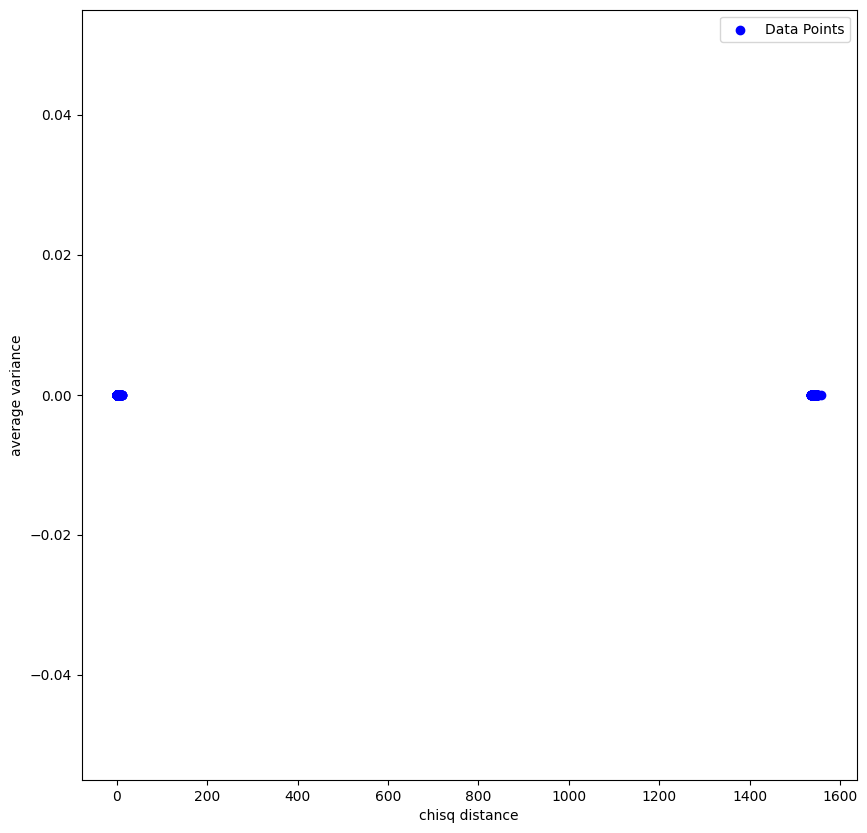

In [13]:
plt.figure(figsize=(10, 10))
plt.scatter(distances, variance_prediction_mean, color='blue', marker='o', label='Data Points')
plt.xlabel("chisq distance")  
plt.ylabel("average variance") 
plt.legend()
plt.show()

In [14]:
parameters_prediction_scale_restored = dataset.scaler_cos_sin.inverse_transform(parameters_prediction)
parameters_prediction_scale_restored = torch.tensor(parameters_prediction_scale_restored)

In [15]:
parameters_prediction_scale_restored_angle = change_trig_to_angle(parameters_prediction_scale_restored)
parameters_prediction_scale_restored_angle

tensor([[ 6.5056e-03,  3.1223e+00,  1.4688e+02,  3.7187e-01,  4.4934e-01],
        [ 6.4346e-03,  1.0828e+00,  5.1919e+01, -1.6672e+00,  2.5387e-01],
        [ 8.7406e-03,  1.1217e+00,  1.7661e+02,  6.1272e-01, -5.3714e-02],
        ...,
        [ 8.0180e-03,  1.4534e+00,  1.6655e+02, -3.7413e-02,  2.0556e-02],
        [ 7.2735e-03,  1.6598e+00,  1.9109e+02, -6.3935e-01, -2.2221e-01],
        [ 7.8292e-03,  1.1356e+00,  1.0319e+02,  1.4271e-01,  2.9879e-02]],
       dtype=torch.float64)

In [16]:
target_parameters_with_angle = dataset.original_targets
target_parameters_with_angle

tensor([[ 8.5000e-03,  3.1300e+00,  1.5818e+02,  5.0000e-02,  3.7000e-01],
        [ 4.0000e-03,  1.0800e+00,  5.1750e+01, -2.1300e+00,  1.7000e-01],
        [ 1.2200e-02,  4.2700e+00,  1.8801e+02,  3.5000e-01, -1.7000e-01],
        ...,
        [ 1.2000e-03,  1.4500e+00,  1.6148e+02, -4.0000e-01, -9.0000e-02],
        [ 1.3000e-02,  1.6600e+00,  1.8984e+02, -1.0500e+00, -3.4000e-01],
        [ 4.0000e-03,  4.2800e+00,  1.0348e+02, -1.6000e-01, -7.0000e-02]],
       dtype=torch.float64)

In [17]:
result_mae = torch.mean(torch.abs(parameters_prediction_scale_restored_angle - target_parameters_with_angle), dim=0)
MIN_PER_COLUMN = torch.min(target_parameters_with_angle, dim=0, keepdim=True)
MAX_PER_COLUMN = torch.max(target_parameters_with_angle, dim=0, keepdim=True)
RANGE_PER_COLUMN = (MAX_PER_COLUMN.values - MIN_PER_COLUMN.values)
RANGE_PER_COLUMN_NUMPY = RANGE_PER_COLUMN.numpy()
print(RANGE_PER_COLUMN)
print(torch.div(result_mae, RANGE_PER_COLUMN) * 100)

tensor([[5.1100e-02, 6.2800e+00, 1.7499e+02, 8.8100e+00, 2.7500e+00]],
       dtype=torch.float64)
tensor([[ 8.4359, 25.0795,  2.3705,  3.5594,  3.6014]], dtype=torch.float64)


In [18]:
variance_prediction

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

In [19]:
distances

tensor([6.5959e-01, 1.7855e+00, 1.5396e+03,  ..., 1.6168e+00, 1.7093e+00,
        1.5385e+03])